# Kinetics II

We continue kinetic analysis, working through integral methods for batch reactor analysis, non-linear regression, and the significance of data linearization.

Note for 2023 -- would be better if Recitation on interpolation and regression can precede kinetics entirely.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Example Problem 01

(Re)Analysis of Data Collected in a Constant Volume Batch Reactor.

We are going to continue analyzing the data set from Lecture 28.  As I mentioned, inverse problems where we try to determine models and parameters from data can be tricky, and it is useful to apply several different methods of analysis if we're able. 

Let's recall that we're considering a single, irreversible reaction:

$$A \longrightarrow B$$

We carry out the reaction in a constant volume batch reactor, and we know the following:

\begin{align}
    C_{A0} &= 10 \ \textrm{mol} \ \textrm{L}^{-1} \\
    C_{B0} &= 0 \ \textrm{mol} \ \textrm{L}^{-1} \\
    T &= \textrm{constant}
\end{align}

We also have measured a set of concentrations (in moles per liter) at various times (in minutes).  These are plotted below.

Our goal:  Determine the rate law (reaction order) and rate constant for this reaction under these conditions.

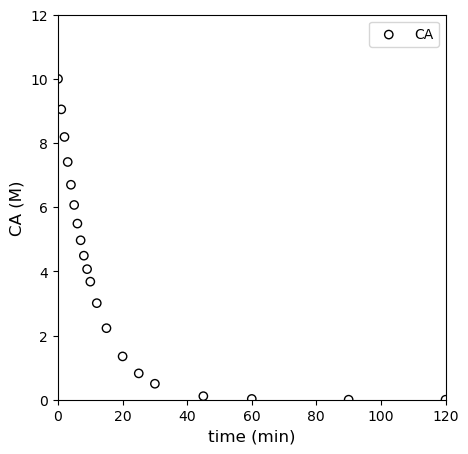

In [3]:
tdata = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 45, 60, 90, 120]) #time in minutes
CAdata = np.array([10, 9.05, 8.19, 7.41, 6.70, 6.07, 5.49, 4.97, 4.49, 4.07, 3.68, 3.01, 2.23, 1.35, 0.821, 0.498, 0.111, 0.0248, 1.23E-3, 6.14E-05])

#Concentrations in moles per liter

plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

### Solution to Example Problem 01

We want to know, based on that data, what is the rate law and corresponding kinetic parameters (k, reaction order, etc.) that best describe that data. With an inverse problem, we have to extract that information from the data. Since this reaction is overall (not an elementary step), at best, we can propose that the rate of reaction depends on temperature (which we capture with a rate constant) and the concentration of the reactant, A, with some unknown order, i.e., we'll propose a power law model:

$$r = k{C_A}^\alpha$$

Our analysis will start with a material balance on species A in a constant volume batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

For a constant volume reactor, we can divide through by V and move it inside of the derivative:

$$\frac{dC_A}{dt} = R_A$$

And for a single reaction, we know that $R_A = -r$, so:

$$\frac{dC_A}{dt} = -r$$

We've proposed power law kinetics here, hence:

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

At this point, we make a decision about whether we want to use a **differential** method of analysis, where we attempt to approximate reaction rates by taking numerical derivatives of data, or an **integral** method of analysis, where we attempt to solve the material balance by integration and then regress parameters in the resultant model that best describe our data.  

In L26, we used a differential method of analysis.  We showed that it is:

1. Quick to apply using finite differences
2. Convenient when you do not know the reaction order as it will be determined by regression
3. Avoids having to guess reaction orders and solve the material balance as with integral methods

On the downside, though:

1. Numerical differentiation is imprecise, and especially so when considering large changes in concentration/time
2. Imprecision arises from the assumption that the derivative is constant over the range considered, a built in feature of finite differences
3. If we aren't careful, a differential analysis can give us a false impression of true reaction kinetics, even for "perfect data" generated by a batch reactor simulation.

Today, we'll consider the integral method of analysis and highlight its strengths and weaknesses.  We'll also take this opportunity to introduce nonlinear regression, which is a very useful skill.

### Integral Analysis

As the name suggests, integral analysis of batch reactor data is based on integration, which entails solving the differential equation that comprises the batch reactor material balance.  Recall from above that we were able to develop the followind ODE that describes the change in the concentration of species a with respect to time -- remember that at this point this is done symbolically for an arbitrary rate constant, $k$, and an arbitrary reaction order $\alpha$.  As of now, we do not know either of their values, so we leave them symbolic in the material balance.

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

In a later lecture, we'll present the symbolic solution for an undetermined value of $\alpha$ and $k$, but I find it better to start with more tangible and straightforward cases to get a feel for integral analysis of data in a batch reactor. Although somewhat tedious, the most straightfoward approach is to assume a reaction order and then check to see if that model describes the measured data. As we'll see below, this can be time consuming, but it has the added advantage of letting us compare multiple models, which can help to inform our decision about which one describes our data the best.

Here, let's assume that the reaction order is either 0, 1, or 2.  Once we do that, we can solve the material balance on A to get an analytical solution for $C_A(t)$, which we can compare to our data.

#### Zero Order Solution

For a zero order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k$$

This is a separable ODE, so we'll solve it by hand (note: it is far better in kinetic analysis if you can obtain an analytical solution than having to resort to a numerical one).

$$\int_{C_{A0}}^{C_A}dC_A = \int_0^t-kdt$$

Which gives:

$$C_A = C_{A0} - kt$$

#### First Order Solution

For a first order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -kC_A$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{C_A}dC_A = \int_0^t-kdt$$

Which gives:

$$C_A = C_{A0}\exp\left(-kt\right)$$

#### Second Order Solution

For a second order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^2$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^2}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$$

To summarize, we have 3 models to compare to our data:

**Zero Order**: $C_A = C_{A0} - kt$  

**First Order**: $C_A = C_{A0}\exp\left(-kt\right)$

**Second Order**: $\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$

We're going to make this comparison in two ways.  First, we will overlay these models directly with our data, which is a plot of concentration vs. time.  Then we'll vary the value of the unknown parameter (k) until we get the best fit for the data. We'll start with a very crude manual approach to get a feel for how this works, we will consider how we can do a better job of quantifying the error between measurement values and model predictions, and then we will look at more sophisticated strategies for minimizing that error.

First, a manual approach with only visual feedback about quality of fit.

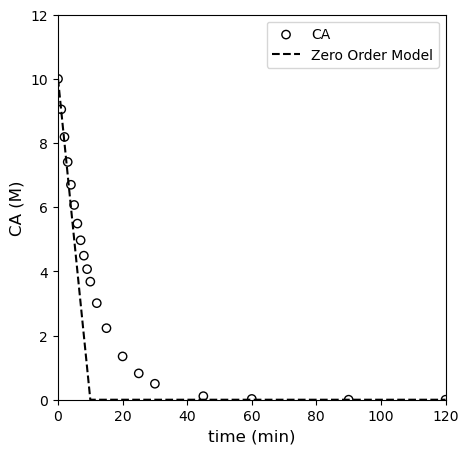

In [5]:
##Testing zero order model

CA0    = 10 #mol/L
ktest    = 1.  #mol/L/min

CAZERO = lambda k, t: CA0 - k*t
CMODZERO = CAZERO(ktest, tdata)
CMODZERO[CMODZERO < 0] = 0   #Note, this is forcing the CA value to go to zero; otherwise a zero order model will go negative

plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODZERO, color = 'black', linestyle = 'dashed', label = 'Zero Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

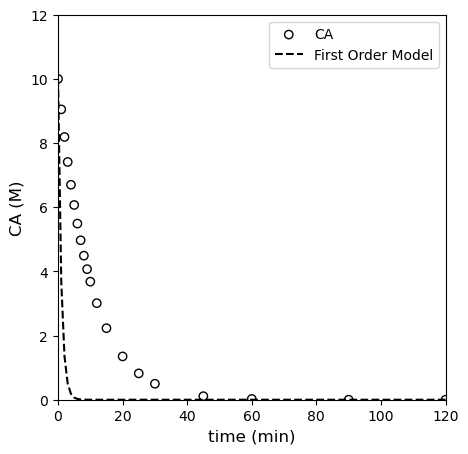

In [7]:
##Testing first order model

CA0    = 10 #mol/L
ktest    = 1.  #mol/L/min

CAONE = lambda k, t: CA0*np.exp(-k*t)
CMODONE = CAONE(ktest, tdata)

plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODONE, color = 'black', linestyle = 'dashed', label = 'First Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

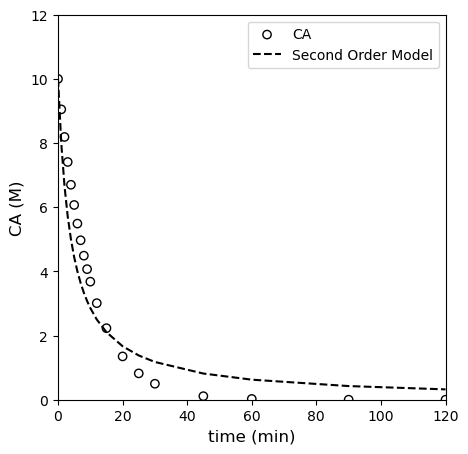

In [8]:
##Testing second order model

CA0    = 10 #mol/L
ktest    = 0.025  #mol/L/min

CATWO = lambda k, t: 1/(1/CA0 + k*t)
CMODTWO = CATWO(ktest, tdata)
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODTWO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

The mathematically rigorous way to find the best value of the rate constant is to find the one that gives the "line of best fit."  That is to say, the best model/rate constant is the one that ***minimizes*** the total error between model predictions and measurement values.

In all of the above, the systems are very overdetermined.  We have 18 data points, and, in each of our models (zero order, first order, and second order), there is only a single unknown (k).  So there won't be a unique solution in any of these cases.  Instead, we find the solution that minimizes the error between our model prediction, which is the heart of regression analysis.

There are many ways to perform a regresion, and you have lots of choices about the nature of the objective function that you're trying to minimize.  Here, we'll keep it simple and do the most common type, which is least-squares regression. Specifically, we will quantify the total error in our system as the sum of square differences between model predictions and measurement values:  

$$SSE = \sum_i \left(\bar{y}_i - \hat{y}_i\right)^2$$

Here, $\bar{y}_i$ is the ith measurement of the observable $y$ at the corresponding value of independent variable, $x_i$, and $\hat{y}$ is the model prediction of the observable value ($y$) at the same condition of independent variable, $x_i$. The quantity in parentheses represents the displacement (or "error") between our model's prediction and our measurement's value.  We square it to ensure that the error is positive -- otherwise, positive and negative errors will average out to zero, making it difficult to identify the true minimum error.

In this case, we'd base our SSE on measured and model predicted values of the concentration of A since that is our observable.

$$SSE = \sum_i \left(\bar{C}_{A_i} - \hat{C}_{A_i}\right)^2$$

Now that we have a lot of experience writing functions to accomplish all sorts of things, it is relatively straightforward to write a function to calculate the sum of squares for a given model at a certain value of rate constant.  We can then look at both the plot *and* the more quantitative sum of square errors for the current parameter value.

In [28]:
def OBJZERO(k):
    CA0    = 10 #mol/L
    tdata = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 45, 60, 90, 120]) #time in minutes
    CAdata = np.array([10, 9.05, 8.19, 7.41, 6.70, 6.07, 5.49, 4.97, 4.49, 4.07, 3.68, 3.01, 2.23, 1.35, 0.821, 0.498, 0.111, 0.0248, 1.23E-3, 6.14E-05])
    
    CAZERO = CA0 - k*tdata  #Use previously defined lambda function here instead
    CAZERO[CAZERO < 0] = 0
    RESID  = CAdata - CAZERO
    SSE    = np.sum(RESID**2)
    
#     plt.figure(1, figsize = (5, 5))
#     plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
#     plt.plot(tdata, CAZERO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
#     plt.xlabel('time (min)', fontsize = 12)
#     plt.ylabel('CA (M)', fontsize = 12)
#     plt.xlim(0, 120)
#     plt.ylim(0, 12)
#     plt.legend()
#     plt.show()
    
    print(SSE)
    return SSE

In [17]:
OBJZERO(0.61)

9.265082556669961


9.265082556669961

#### Minimizing the error with numerical tools

It is of course better to use numerical methods to find the value of the parameter that minimizes our objective function (SSE).  We use the exact same approach for minimizing the SSE as we've been using for things like yield and reactor volume. Generally speaking, we do this with `opt.minimize_scalar()` for univariate problems and `opt.minimize()` for multivariate problems.

We'll consider the zero order model first:

944.19865455667
53.900482556669964
245.864831788854
53.900482556669964
153.7556620729141
9.17556480429396
51.056828694573575
10.938882372391399
9.263664712780669
9.17952121344172
9.166992370993569
9.166992370993627
9.166992370993633
0.621405835543767 9.166992370993569


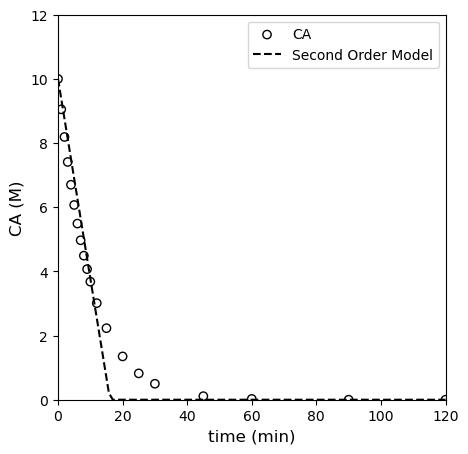

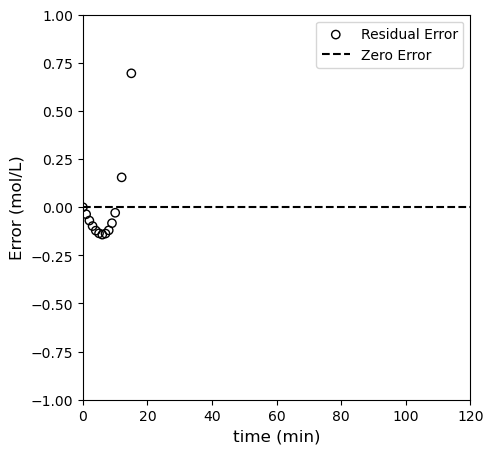

In [44]:
ans_zero = opt.minimize_scalar(OBJZERO)#, method = 'Brent', bracket = [0.01, 10])
SSE      = ans_zero.fun
k_zero   = ans_zero.x
print(k_zero, SSE)

#Calculate result for best fit zero order model
tsmooth = np.linspace(0, max(tdata), 100)
CA0    = 10 #mol/L
CMODZERO = CAZERO(k_zero, tsmooth)#CA0 - k_zero*tsmooth
CMODZERO[CMODZERO < 0] = 0

#Overlay best fit model with data
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, CMODZERO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

#Overlay best fit model with data
plt.figure(2, figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAZERO(k_zero, tdata))/CAdata, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 120, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Error (mol/L)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(-1, 1)
plt.legend(loc = 'upper right')
plt.show()

#### Analysis of Zero Order Fit

Based on that result, the best fit value of the rate constant in a zero order model is 0.621, which achieves a minimum SSE of ~9.1.  Visually, it does an OK job of fitting data at low times, but it falls apart after about 10 - 15 minutes.  We notice that the zero order model over-predicts measured concentration at short times, and it underpredicts at long times.  This would be a sign that the order of reaction is too low.

Now we'll do the same optimization with a first order model.

#### First order optimization

In [30]:
def OBJONE(k):
    CA0    = 10 #mol/L
    tdata = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 45, 60, 90, 120]) #time in minutes
    CAdata = np.array([10, 9.05, 8.19, 7.41, 6.70, 6.07, 5.49, 4.97, 4.49, 4.07, 3.68, 3.01, 2.23, 1.35, 0.821, 0.498, 0.111, 0.0248, 1.23E-3, 6.14E-05])
    
    CAONE  = CA0*np.exp(-k*tdata)
    RESID  = CAdata - CAONE
    SSE    = np.sum(RESID**2)
    print(SSE)
    return SSE

944.19865455667
323.36071947412506
393.91900286691435
323.36071947412506
367.8748290995288
258.13030776184183
173.49125626053535
83.64181125445307
17.645767419631596
1.3418110730482369
16.469424370441473
0.5959665956334185
0.0003430618140482097
0.0016049707341570932
0.000109649223105198
0.00010897622293589579
0.00010897547817903003
0.00010897547788735623
0.00010897547791498506
0.00010897547791563169
0.09998050415599218 0.00010897547788735623


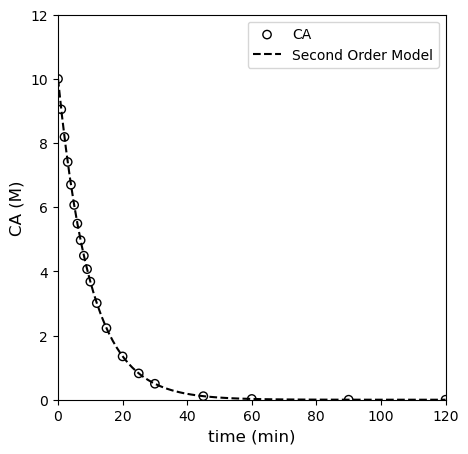

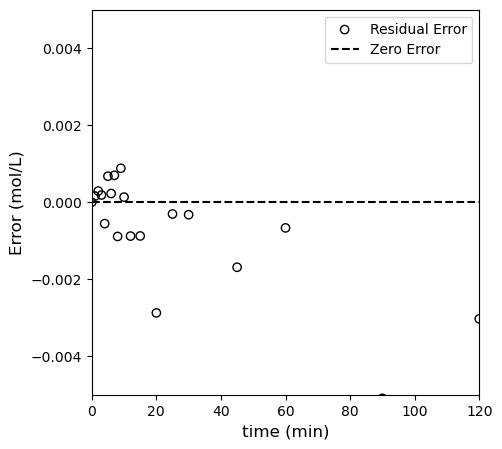

In [40]:
#Run Optimization
ans_one = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 10])
SSE     = ans_one.fun
k_one   = ans_one.x
print(k_one, SSE)

#Calculate results for best fit first order model
tsmooth = np.linspace(0, max(tdata), 100)
CA0     = 10 #mol/L
CMODONE = CAONE(k_one, tsmooth) #CA0*np.exp(-k_one*tsmooth)

#Overlay best fit model with data
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, CMODONE, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

#Overlay best fit model with data
plt.figure(2, figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAONE(k_one, tdata))/CAdata, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 120, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Error (mol/L)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(-0.005, 0.005)
plt.legend(loc = 'upper right')
plt.show()

Well, that one pretty much nails it.  It estimates a best fit rate constant of 0.1 (which is exactly what I used to generate the data), and the SSE is $10^{-4}$. It really can't get better than that, but let's see what the optimum result for second order looks like too.

#### Second order optimization

In [33]:
def OBJTWO(k):
    CA0    = 10 #mol/L
    tdata = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 45, 60, 90, 120]) #time in minutes
    CAdata = np.array([10, 9.05, 8.19, 7.41, 6.70, 6.07, 5.49, 4.97, 4.49, 4.07, 3.68, 3.01, 2.23, 1.35, 0.821, 0.498, 0.111, 0.0248, 1.23E-3, 6.14E-05])
    
    CATWO  = 1/(1/CA0 + k*tdata)
    RESID  = CAdata - CATWO
    SSE    = np.sum(RESID**2)
    print(SSE)
    return SSE

944.19865455667
367.2296218590384
391.27600361125957
367.2296218590384
381.78478705356366
345.54513508325607
314.550484725592
272.67569898183996
220.06376899409693
159.6986125655918
98.12118437983854
45.37201122060032
13.568626886488474
13.638892423841824
9.185521487892382
9.179129120575118
9.110387291498567
9.773029448945811
9.099494914885135
9.099496163799184
9.099492548658832
9.099492548652368
9.099492548652323
9.099492548652348
0.016694686189028692 9.099492548652323


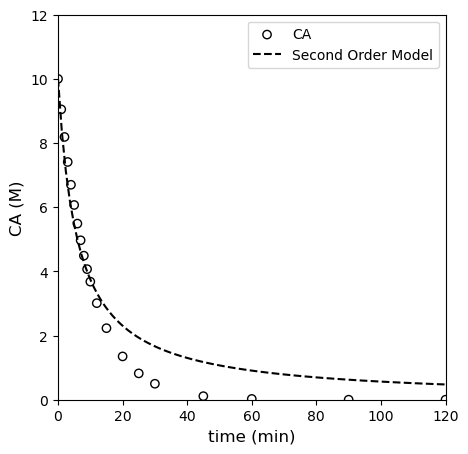

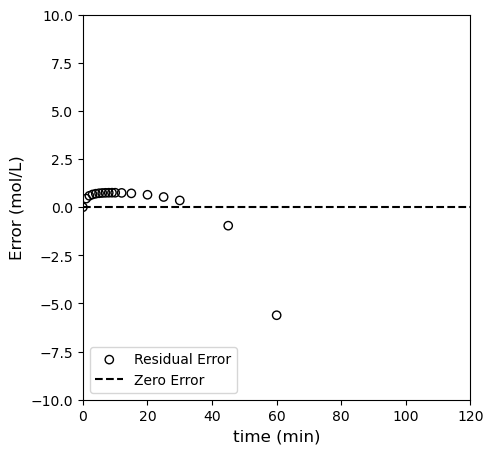

In [39]:
#Run Optimization
ans_two = opt.minimize_scalar(OBJTWO)#, method = 'Brent', bracket = [0.01, 10])
SSE     = ans_two.fun
k_two   = ans_two.x
print(k_two, SSE)

#Overlay best fit model with data
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, CMODTWO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

#Overlay best fit model with data
plt.figure(2, figsize = (5, 5))
plt.scatter(tdata, (CAdata - CATWO(k_one, tdata))/CAdata, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 120, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Error (mol/L)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(-10, 10)
plt.legend(loc = 'lower left')
plt.show()

Now we have the opposite problem compared to the zero order case -- the second order model under-predicts concentration at short times, and it over-predicts their values at long times.  This is a sign that the order it too high.  Clearly, the first order model is "just right" here as it is the one that fits the data best.

Here, we've generally used "nonlinear" regression because the models that we fit for first order and second order were non-linear functions of time.  This is a powerful technique but it can also lead to problems.  Most notably, when have data that is nonlinear, it is supposed to be curved in some way.  It can be hard to tell if the amount of curvature is correct.  In this case, it is easy to see, but recall that this is actually a perfect data set that I generated by solving a first order system.  When we have messy, "real" data, it can be difficult to tell if the type of curvature observed in your model is correct, and it can be hard to resolve whether one nonlinear model is better than the other.

Where it is possible to do so, it is always useful to linearize a model.  This gains us a couple of important things.

1. Whereas deviation between experimental data and a curved line can be difficult to assess, it is relatively easy to detect deviations from linearity.  This makes linearization a powerful visual tool for assessing goodness of fit.
2. If we can linearize a model, we can use linear regression tools.  Regardless of how they are packaged (e.g., trendline in Excel or polyfit in Python), they are all based on similar methods that use linear algebra.  
3. They key here is that linear regression solutions are deterministic.  There **is** a unique solution for the parameters that give us the best fit if we use linear regression. 
4. With nonlinear regression (as above), we are forced to use an interative optimization routine (like opt.minimize or opt.minimize_scalar), which is not necessarily guaranteed to converge.  The linear algebra solutions will be much more stable, which can be very beneficial in difficult optimization problems.

For these reasons, we'll consider how to linearize these models, perform linear regressions, and visually inspect the results compared to a linearized data set.

### Linearized Models

The zero order model is easy to linearize because it is already linear in time.  Looking at it, we expect that if we plot CA vs time, the trend should be linear if the kinetics are zero order.

$$C_A = C_{A0} - kt$$

We do this below; clearly the data are not linear, but we'll work through the regression anyway just to get some practice.

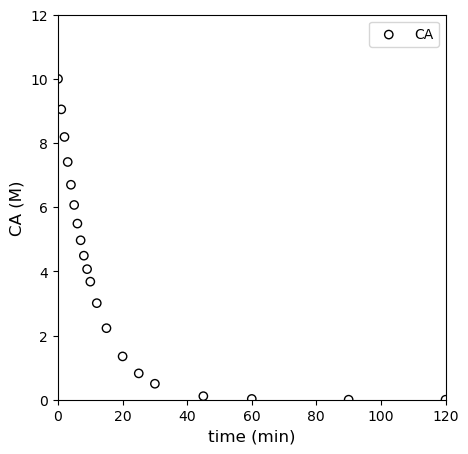

In [45]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()
plt.show()

So we want to take that ostensibly linear data set (our zero order model says it is linear...) and perform linear regression on it.  We'd do this with the typical vandermonde matrix approach, where we use the model:

$$C_A = C_{A0} - kt$$

But that generally translates to the generic form with two coefficients:

$$\alpha_1t + \alpha_0 = C_A$$ 

We'd write a copy of that equation for every data point collected, which would give us an overdetermined system of equations (18 equations and two unknown $\alpha$'s).  Technically, we know $C_{A0}$ here, but we'll move forward treating it as an unknown coefficient in the model (the y-intercept).  That ends up in our usual matrix form:

$$XA = Y$$

Where "X" is the Vandermonde matrix truncated to include only $x^0$ and $x^1$ terms.  Y is the set of measured concentrations.  We'd solve this as usual using methods of linear algebra.

In [48]:
X = np.vander(tdata[0:11], 2) #Note I'm truncating data to the first 10 points or so; thereafter, zero order model goes negative
Y = CAdata[0:11]
print(Y)
print(X)

[10.    9.05  8.19  7.41  6.7   6.07  5.49  4.97  4.49  4.07  3.68]
[[ 0  1]
 [ 1  1]
 [ 2  1]
 [ 3  1]
 [ 4  1]
 [ 5  1]
 [ 6  1]
 [ 7  1]
 [ 8  1]
 [ 9  1]
 [10  1]]


In [49]:
A = np.linalg.solve(X.T@X, X.T@Y)
print(A)

[-0.62463636  9.49772727]


In [51]:
np.polyfit(tdata[0:11], Y, 1)

array([-0.62463636,  9.49772727])

**First Order Model**

For the first order model, we have:

$$C_A = C_{A0}\exp(-kt)$$

This is a nonlinear function of, essentially kt; however, if we take the natural logarithm of both sides, we convert it to the following, which is much more useful:

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - kt$$

If we plot $C_A$ against time, that should be linear if the first order model is correct.  The slope would be equal to -k, and the y-intercept would be ln(CA0).  In the matrix form:

$$\alpha_1t + \alpha_0 = \ln\left(C_A\right)$$

We can put this into the vandermonde form:

$$XA = Y$$

Where X is the vandermonde matrix generated from tdata (and truncated to include only zero order and first order terms), and Y is the natural log of CA.

This is plotted in the cell below, where you observe linearity.

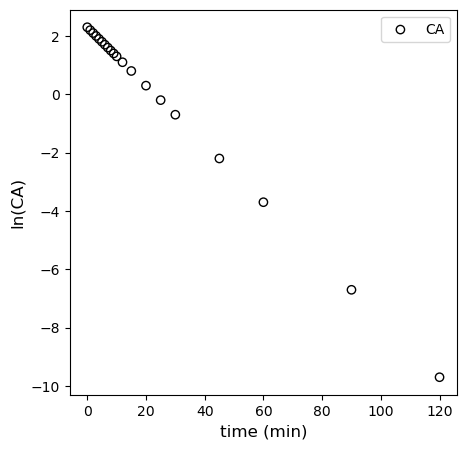

In [52]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, np.log(CAdata), edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('ln(CA)', fontsize = 12)
# plt.xlim(0, 120)
# plt.ylim(0, 12)
plt.legend()
plt.show()

In [30]:
X = np.vander(tdata, 2)
Y = np.log(CAdata)
A = np.linalg.solve(X.T@X, X.T@Y)
k = -1*A[0]
CAest = np.exp(A[1])
print(k, CAest)

0.10001587909135363 10.001395241781244


Alternatively, you can use polyfit.  You get the exact same results; I'm pretty sure it is just a convenience function that automates what we did with matrices above.  We'll use those coefficients to add the line of best fit to our linearized first order data.  You can see that it describes the data very well.

In [53]:
coeffs = np.polyfit(tdata, np.log(CAdata), 1)
k = -1*coeffs[0]
CAest = np.exp(coeffs[1])
print(k, CAest)

0.10001587909135363 10.001395241781244


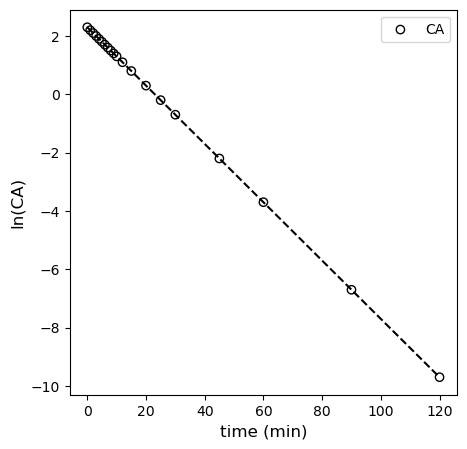

In [54]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, np.log(CAdata), edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, np.polyval(coeffs, tsmooth), color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('ln(CA)', fontsize = 12)
# plt.xlim(0, 120)
# plt.ylim(0, 12)
plt.legend()
plt.show()

**Second Order Model**

For the second order model, we have:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

We should see linearity here if we plot $\frac{1}{C_A}$ vs $t$.  See below.  Deviation from linearity is clearly observed.

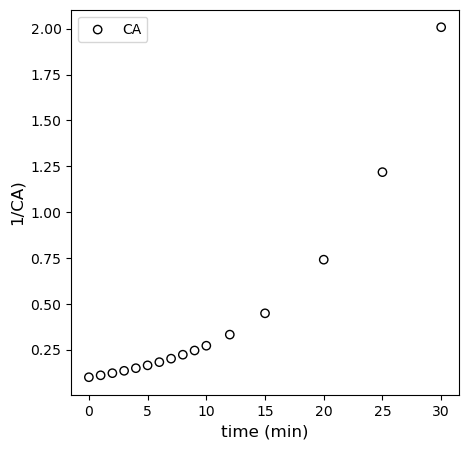

In [55]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata[:-4], 1/CAdata[:-4], edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('1/CA)', fontsize = 12)
# plt.xlim(0, 120)
# plt.ylim(0, 12)
plt.legend()
plt.show()
plt.show()

Below, I regress the coefficients for the linearized second order model using polyfit and overlay it with the "linearized" data set.

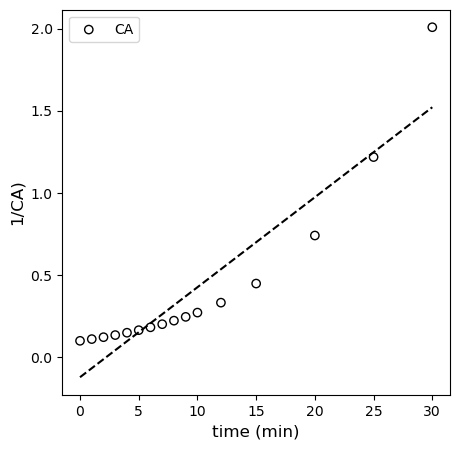

In [56]:
tsmooth = np.linspace(0, 30, 100)
coeffs = np.polyfit(tdata[:-4], 1/CAdata[:-4], 1)
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata[:-4], 1/CAdata[:-4], edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, np.polyval(coeffs, tsmooth), color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('1/CA)', fontsize = 12)
# plt.xlim(0, 120)
# plt.ylim(0, 12)
plt.legend()
plt.show()
plt.show()

### Discuss after recitation

Clearly, from all of this, we can see that the first order model fits the data best, and our regressed parameters tell us that the rate constant is 0.1 inverse minutes, which is exactly what I used to generate the data.

As a final point, some of you may question why, with our linearized first order model:

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - kt$$

We bothered to regress the y-intercept since we already know the value of $C_{A0}$ for this experiment.  Good observation.  In general, the precision of our estimates by regression decreases as we estimate more parameters.  So, for an optimization where I already know a parameter, $C_{A0}$ in this case, it's probably best if I don't introduce uncertainty by regressing a parameter whose value I'm sure of.  How could you fix it at the known quantity?

Two ways:

1. We use the nonlinear regression approach above, since this gives us complete control over the parameters we estimate.
2. We re-work the linear form of the model and corresponding vandermonde matrix such that we don't estimate the y-intercept.  

Let's look at the latter.  Our original model was

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - kt$$

And we wrote that as:

$$\alpha_1t + \alpha_0 = \ln\left(C_A\right)$$

But, since I actually know $C_{A0}$, I could instead do the following linearization.  This would allow me to regress only the rate constant.

$$\ln\left(\frac{C_A}{C_{A0}}\right) = - kt$$

In this form, I would plot $\ln\left(\frac{C_A}{C_{A0}}\right)$ vs. t.  In matrix form, this becomes:

$$\alpha_1t = \ln\left(\frac{C_A}{C_{A0}}\right)$$

$$XA = Y$$

Where X is a vandermonde matrix created from tdata; however, we only keep the first order powers of time here (since there is no zero order coefficient in the model).  Y, in this case, is $\ln\left(\frac{C_A}{C_{A0}}\right)$, and A is only a single coefficient, namely the slope of the line.  See below for implementation.  We can't use polyfit here, but if we know how to work with the vandermonde matrix, we have a lot of flexibility in regressions.  This is similar to what you can do with the LINEST function in Excel.

-0.10001374135540081


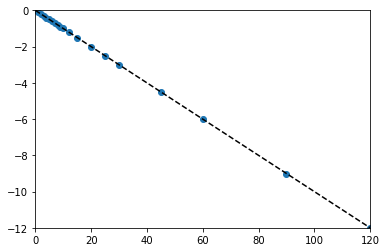

In [46]:
tsmooth = np.linspace(0, 120, 100)
X = tdata.reshape(len(tdata),1)
Y = np.log(CAdata/CA0)
A = np.linalg.solve(X.T@X, X.T@Y)
k = A[0]
print(k)
plt.scatter(X, Y)
plt.xlim(0, 120)
plt.ylim(-12, 0)
plt.plot(tsmooth, A[0]*tsmooth, color = 'black', linestyle = 'dashed')